In [234]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics, EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack, Downloads, URIs, CSV, MathML, NLopt, Plots, StatsPlots, OptimizationBBO
@info "usings"
MTK = ModelingToolkit
EMA = EasyModelAnalysis
meqs = MTK.equations
total_pop = 30_000_000
dd = "/Users/anand/.julia/dev/EasyModelAnalysis/data"

┌ Info: usings
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:2


"/Users/anand/.julia/dev/EasyModelAnalysis/data"

In [214]:
include("demo_functions.jl")

stitched_ensemble_df (generic function with 1 method)

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

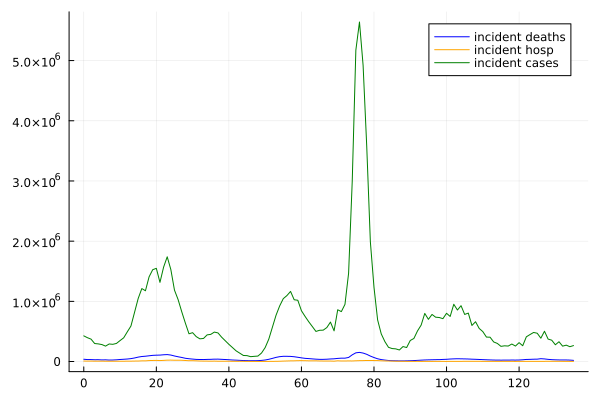

In [132]:
df, dfc, dfd, dfh, covidhub = get_dataframes()
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest (in weeks)
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [133]:
N_weeks = 20; period_step = 10; train_weeks=10 # 10 weeks of training data, 10 weeks of testing
all_ts = df.t
dfs = select_timeperiods(df, N_weeks; step=period_step)
split_dfs = [train_test_split(df; train_weeks=train_weeks) for df in dfs]
train_dfs, test_dfs = unzip(split_dfs)

(DataFrame[10×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228
   6 │     5  281799   26604   5821
   7 │     6  256026   28030   5071
   8 │     7  291617   24191   5275
   9 │     8  286018   25358   5347
  10 │     9  300436   28491   4953, 10×4 DataFrame
 Row │ t      cases    deaths  hosp  
     │ Int64  Int64    Int64   Int64 
─────┼───────────────────────────────
   1 │    10   348113   33744   5113
   2 │    11   394038   37562   5144
   3 │    12   493557   41729   5863
   4 │    13   589923   48331   6133
   5 │    14   818658   59224   7558
   6 │    15  1048060   73406   8317
   7 │    16  1212395   83419  11241
   8 │    17  1175780   88260  11034
   9 │    18  1406989   95431  16127
  10 │    19  1525551  102441  17509, 10

### Loading the Petri nets for our ensemble and converting them to ODESystems

In [237]:
petri_fns = [
    "BIOMD0000000955_miranet.json",
    "BIOMD0000000960_miranet.json",
    "BIOMD0000000983_miranet.json",
]

petris, syss, defs = load_ensemble(petri_fns)
all_syms = [sys_syms(sys) for sys in syss];
petris[1]

PropertyLabelledReactionNet{Number, Number, Dict} with elements T = 1:16, S = 1:11, I = 1:20, O = 1:20
┌────┬───────┬───────┬──────────────────────────────────────────────────────────
│  T │  rate │ tname │                                                         ⋯
├────┼───────┼───────┼──────────────────────────────────────────────────────────
│  1 │ 0.011 │    t1 │           Dict{String, Any}("mira_rate_law_mathml"=>"<a ⋯
│  2 │ 0.456 │    t2 │ Dict{String, Any}("mira_rate_law_mathml"=>"<apply><time ⋯
│  3 │ 0.011 │    t3 │ Dict{String, Any}("mira_rate_law_mathml"=>"<apply><time ⋯
│  4 │  0.57 │    t4 │                       Dict{String, Any}("mira_rate_law_ ⋯
│  5 │ 0.171 │    t5 │                                                         ⋯
│  6 │ 0.125 │    t6 │                                                         ⋯
│  7 │ 0.034 │    t7 │                                                         ⋯
│  8 │ 0.125 │    t8 │                                                         ⋯
│  9 │ 0.034 │    t9 │                                                         ⋯
│ 10 │ 0.371 │   t10 │                                                         ⋯
│ 11 │ 0.017 │   t11 │                                                         ⋯
│ 12 │ 0.017 │   t12 │                                                         ⋯
│ 13 │ 0.027 │   t13 │                                                         ⋯
│ 14 │ 0.017 │   t14 │                                                         ⋯
│ 15 │  0.01 │   t15 │                                                         ⋯
│ 16 │ 0.017 │   t16 │                                                         ⋯
└────┴───────┴───────┴──────────────────────────────────────────────────────────
                                                                1 column omitted
┌────┬───────────────┬──────────────────┬───────────────────────────────────────
│  S │ concentration │            sname │                                      ⋯
├────┼───────────────┼──────────────────┼───────────────────────────────────────
│  1 │      0.999996 │      Susceptible │                                      ⋯
│  2 │    3.33333e-6 │         Infected │                                      ⋯
│  3 │    3.33333e-7 │        Diagnosed │                                      ⋯
│  4 │    1.66667e-8 │           Ailing │ Dict{String, Any}("mira_concept"=>"{ ⋯
│  5 │    3.33333e-8 │       Recognized │                                      ⋯
│  6 │           0.0 │           Healed │                                      ⋯
│  7 │           0.0 │       Threatened │                                      ⋯
│  8 │           0.0 │          Extinct │                                      ⋯
│  9 │           0.0 │            Cases │                                      ⋯
│ 10 │           0.0 │ Hospitalizations │                                      ⋯
│ 11 │           0.0 │           Deaths │                                      ⋯
└────┴───────────────┴──────────────────┴───────────────────────────────────────
                                                                1 column omitted
┌────┬────┬────┐
│  I │ it │ is │
├────┼────┼────┤
│  1 │  1 │  3 │
│  2 │  1 │  1 │
│  3 │  2 │  4 │
│  4 │  2 │  1 │
│  5 │  3 │  5 │
│  6 │  3 │  1 │
│  7 │  4 │  2 │
│  8 │  4 │  1 │
│  9 │  5 │  2 │
│ 10 │  6 │  2 │
│ 11 │  7 │  2 │
│ 12 │  8 │  3 │
│ 13 │  9 │  3 │
│ 14 │ 10 │  4 │
│ 15 │ 11 │  4 │
│ 16 │ 12 │  4 │
│ ⋮  │ ⋮  │ ⋮  │
└────┴────┴────┘
  4 rows omitted
┌────┬────┬────┐
│  O │ ot │ os │
├────┼────┼────┤
│  1 │  1 │  3 │
│  2 │  1 │  2 │
│  3 │  2 │  4 │
│  4 │  2 │  2 │
│  5 │  3 │  5 │
│  6 │  3 │  2 │
│  7 │  4 │  2 │
│  8 │  4 │  2 │
│  9 │  5 │  3 │
│ 10 │  6 │  4 │
│ 11 │  7 │  6 │
│ 12 │  8 │  5 │
│ 13 │  9 │  6 │
│ 14 │ 10 │  5 │
│ 15 │ 11 │  6 │
│ 16 │ 12 │  7 │
│ ⋮  │ ⋮  │ ⋮  │
└────┴────┴────┘
  4 rows omitted

### Adjust all model defaults to be standardized to population, not proportion of population, then convert to simulatable ODEProblems

In [135]:
# adjust the defaults to be in terms of the total population. now all 3 models have defaults in terms of pop
# this is a weak link in the workflow
# TODO: scale the outputs for loss instead of the u0

global opt_step_count = 0
for i in 1:2 # only the first two are in proportions 
    for st in states(syss[i])
        defs[i][st] *= total_pop # this mutates the return of ModelingToolkit.defaults
    end
end

In [136]:
# modifiying the observed to be *= total_pop will be the fix for above, since they dont affect dynamics.
observed.(syss)

3-element Vector{Vector{Equation}}:
 [Deaths(t) ~ Extinct(t), Hospitalizations(t) ~ Recognized(t) + Threatened(t), Cases(t) ~ Diagnosed(t) + Hospitalizations(t)]
 [Cases(t) ~ Infectious(t), Hospitalizations(t) ~ Hospitalized(t), Deaths(t) ~ Deceased(t)]
 [Cases(t) ~ Infected_reported(t), Deaths(t) ~ Deceased(t), Hospitalizations(t) ~ h*Infected_reported(t)]

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 

Since the MiraNet schema encodes the observables (Cases, Deaths, Hospitalizations) uniformly through all models in the ensemble, we only need to provide a single list of Model observable => column name

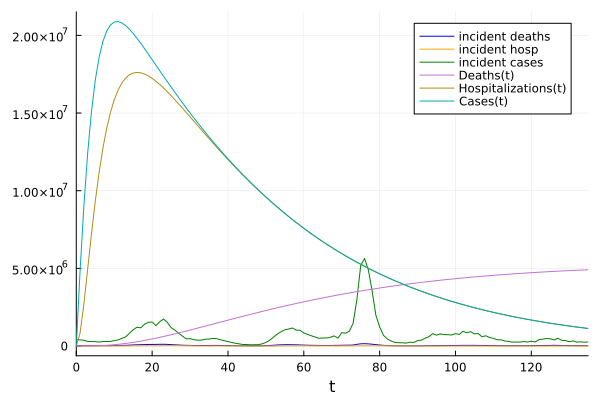

In [192]:
sys = syss[1]
syms = all_syms[1]

@unpack Deaths, Hospitalizations, Cases = sys
obs_sts = [Deaths, Hospitalizations, Cases]
mapping = Dict([Deaths => :deaths, Cases => :cases, Hospitalizations => :hosp])

prob = ODEProblem(sys, defs[1], extrema(all_ts), defs[1])
sol = solve(prob;saveat=all_ts)
plt = plot_covidhub(df)
plot!(plt, sol; idxs=obs_sts)

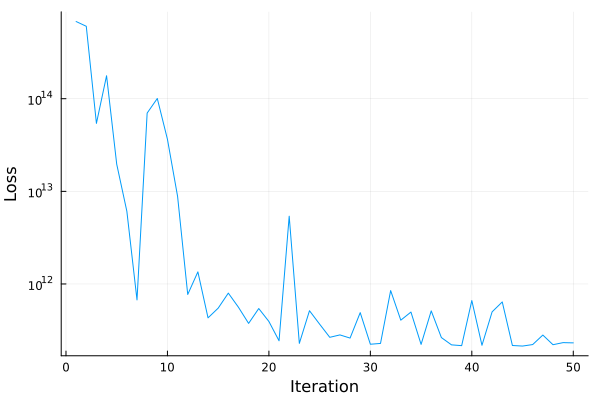

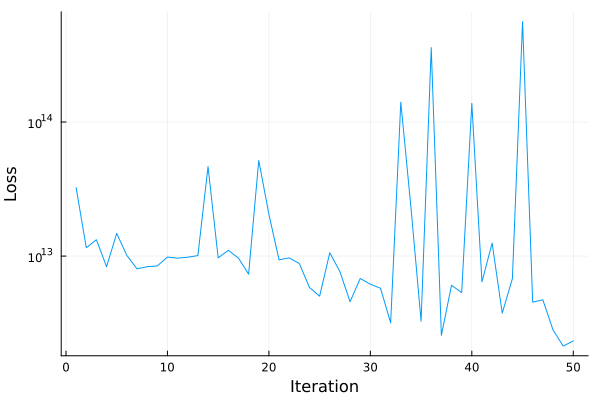

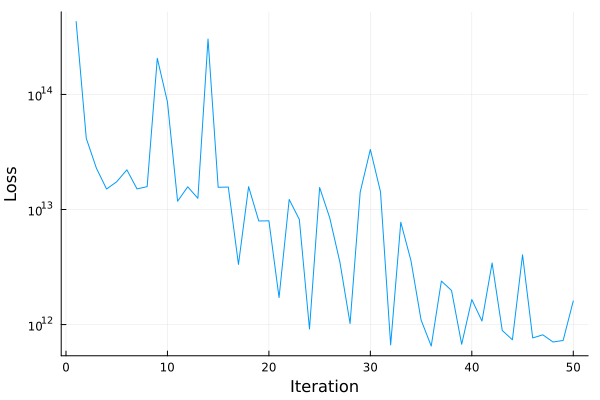

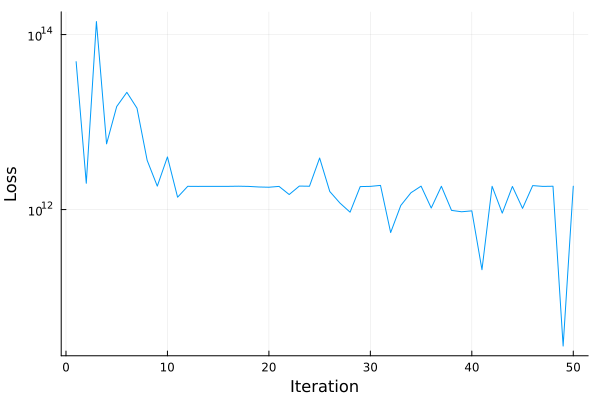

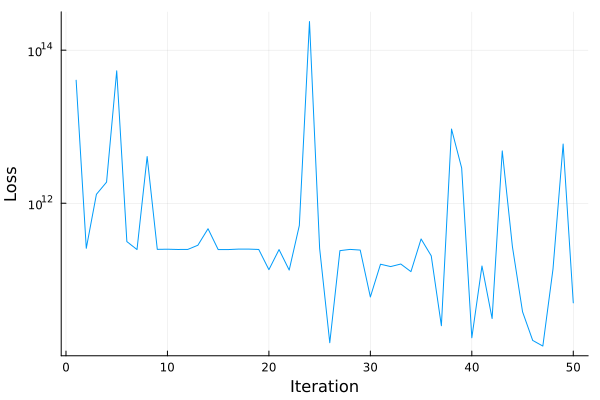

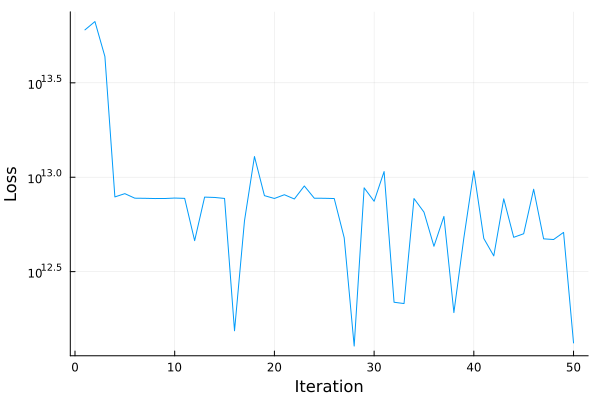

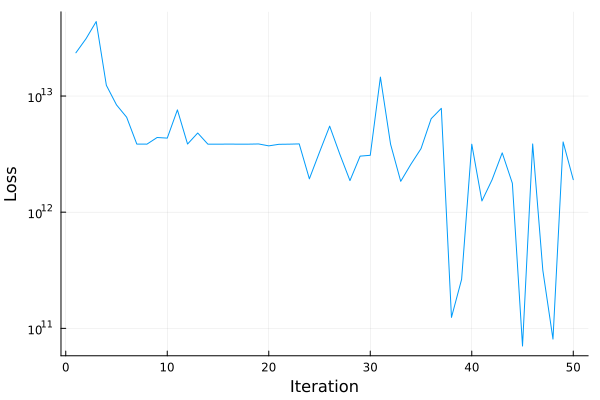

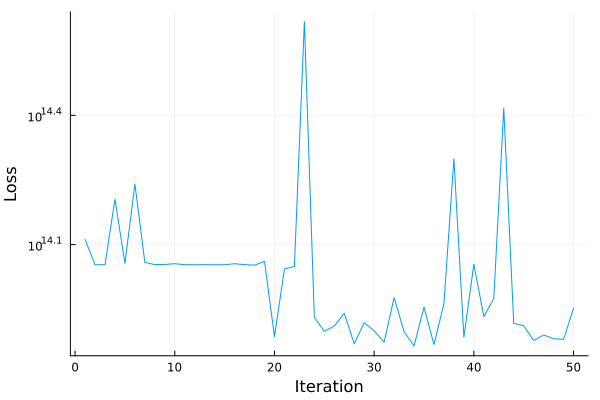

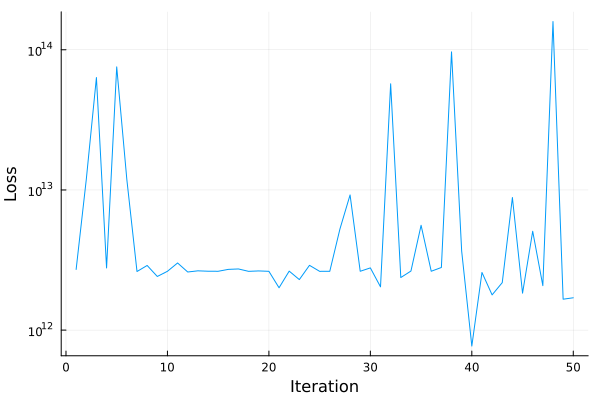

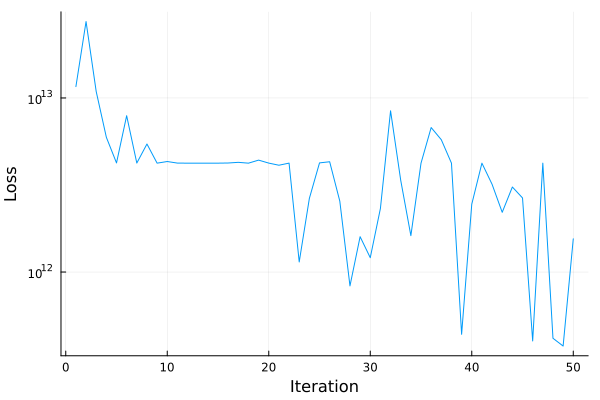

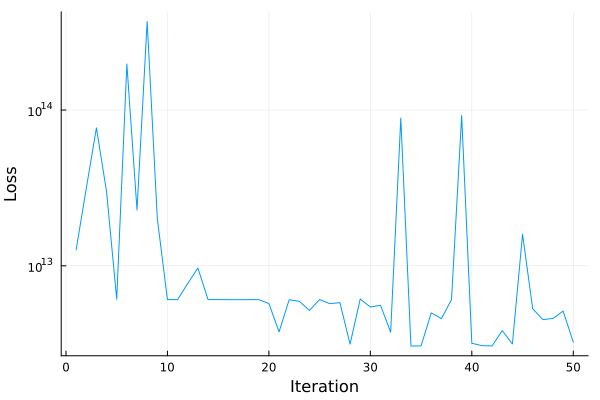

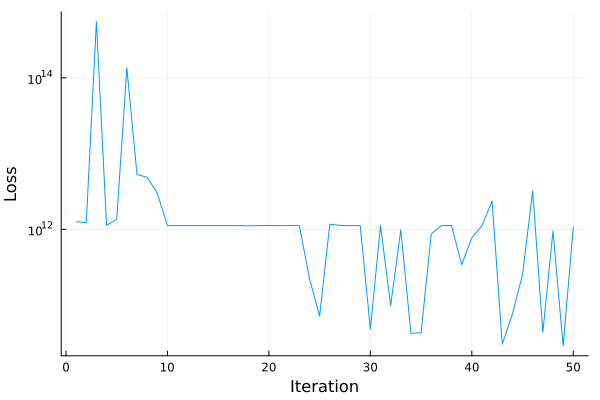

In [174]:
single_model_fits = global_ensemble_fit([prob], train_dfs, mapping; maxiters=5000, doplot=true);
# there is one plot/fit per timeperiod per model (so 12)

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


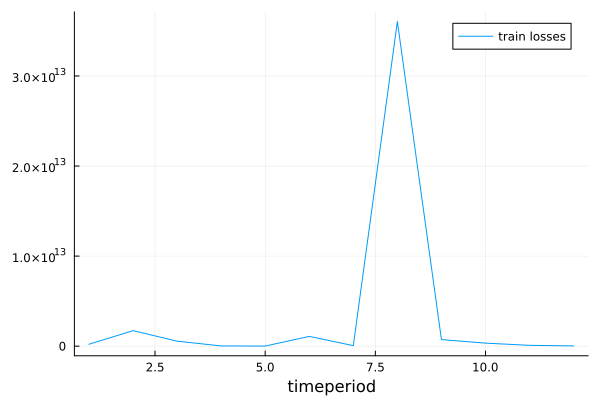

In [235]:
# TODO: to separate into train and test losses, i need to simulate train up until t0 of test, remake with that u0, then forecast for the test period
losses, test_losses, remade_probs, remade_solutions = calculate_losses_and_solutions(single_model_fits, [prob], dfs, mapping);
plot(losses[1, :];label="train losses");
xaxis!("timeperiod")


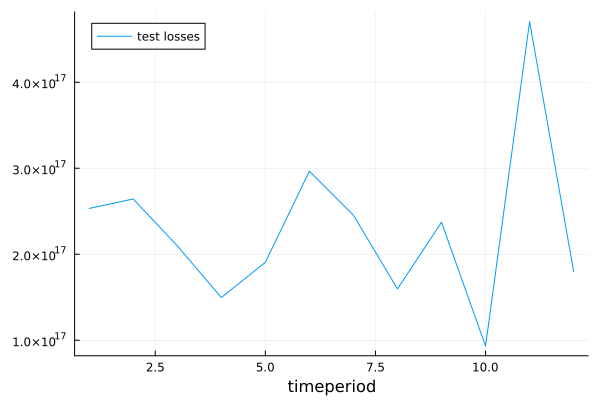

In [236]:
plot(test_losses[1, :]; label="test losses");
xaxis!("timeperiod")
# one thing that might be useful is seeing how the test loss increases as we forecast further out, since we are attempting to forecast 10 weeks here

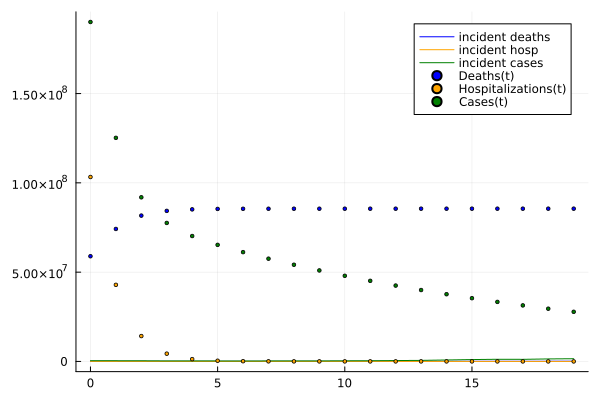

In [204]:
forecast_plot(dfs[1], [remade_solutions[1][1]])

### Tabular results of fitting for each timeperiod for a single model

In [194]:
fitdf = fitvec_to_df(single_model_fits[1], syms)

12×40 DataFrame
 Row │ Susceptible     Infected   Diagnosed      Ailing     Recognized  Healed ⋯
     │ Float64         Float64    Float64        Float64    Float64     Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      3.29554e7  4.22862e7      8.67981e7  3.42156e7   7.45822e7  4.3761 ⋯
   2 │ 134100.0        5.98656e7      8.11903e7  2.58788e7   8.83172e7  2.6596
   3 │      2.68207e7  7.41809e7      8.50005e7  8.19176e7   8.2403e7   4.8630
   4 │      8.91628e7  4.04088e7      2.28066e7  6.11345e7   1.77779e7  9.4394
   5 │      4.49632e7  4.95259e7      7.86036e7  3.56803e7   6.63578e7  8.6372 ⋯
   6 │      4.96229e7  2.62915e7      3.96602e7  9.35054e6   6.26416e7  7.2278
   7 │      1.84808e7  7.01818e7      4.54188e7  4.1066e7    6.86158e7  7.3743
   8 │      4.86975e7  7.09529e7      3.70563e7  1.43441e7   8.57204e7  8.0484
   9 │      3.98845e6  8.84595e7  30696.4        2.03029e7   1.71226e7  8.0160 ⋯
  10 │      4.62818e6  7.89047e7      1.66371e7  5.83076e7   4.75755e7  9.1394
  11 │      8.95352e7  7.186e7        7.68854e7  7.03284e7   7.24782e5  6.5183
  12 │      9.79764e6  8.28303e7      6.01594e7  7.45871e7   4.10852e7  6.2651
                                                              35 columns omitted

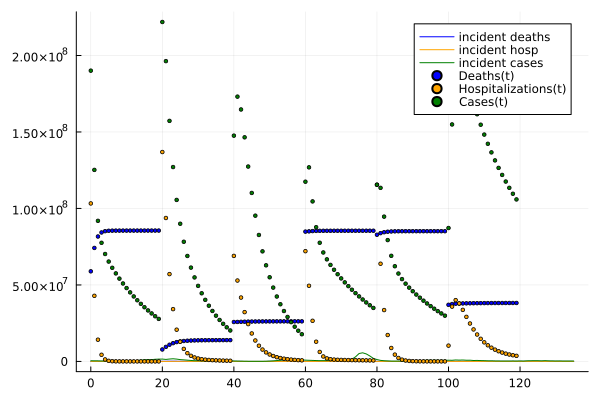

In [242]:
plt = forecast_plot(df, remade_solutions[1][1:2:end])

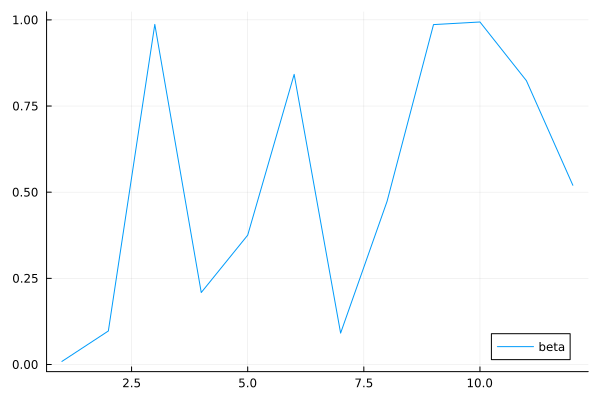

In [140]:
# plot how beta was fit for each timeperiod for model 1
plot(fitdf.beta; label="beta", xaxis="timeperiod")

5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


In [ ]:
# now multiple models 
odeprobs = [ODEProblem(sys, [], extrema(all_ts)) for sys in syss];
ensemble_fits = global_ensemble_fit(odeprobs, train_dfs, mapping; maxiters=2000, doplot=false) # 2000 for speed, the API can parallelize, so I won't do it here

In [213]:
ensemble_losses, ensemble_test_losses, ensemble_remade_probs, ensemble_sols = calculate_losses_and_solutions(ensemble_fits, odeprobs, dfs, mapping);
fitdfs = [fitvec_to_df(fit, all_syms[i]) for (i, fit) in enumerate(ensemble_fits)]

3-element Vector{DataFrame}:
 12×40 DataFrame
 Row │ Susceptible  Infected   Diagnosed  Ailing     Recognized  Healed     Th ⋯
     │ Float64      Float64    Float64    Float64    Float64     Float64    Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   7.66609e6  2.19395e7  3.15156e7  3.81439e7   9.54305e7  8.04644e7   8 ⋯
   2 │   9.13043e7  2.69049e7  1.92563e7  4.9112e6    2.92584e6  1.62849e5   6
   3 │   7.74472e7  8.84152e7  9.56705e7  8.47313e7   6.86774e7  7.04674e7   3
   4 │   5.89399e7  3.83792e7  6.73437e7  3.00328e7   3.4506e7   4.60618e7   6
   5 │   6.20136e7  1.75628e7  7.81394e7  9.15195e7   4.70229e7  5.41878e7   6 ⋯
   6 │   7.85276e7  9.60823e7  4.29123e7  6.87009e7   7.26196e7  1.82315e7   1
   7 │   4.83747e7  8.28805e7  1.50416e7  3.97701e7   5.71778e7  9.6587e7    7
   8 │   5.96229e7  7.17959e7  2.05951e7  2.58785e7   3.32276e6  5.5687e7    3
   9 │   1.57861e7  7.53951e6  5.99005e7  4.24702e7   6.1721e7   8.00837e7 

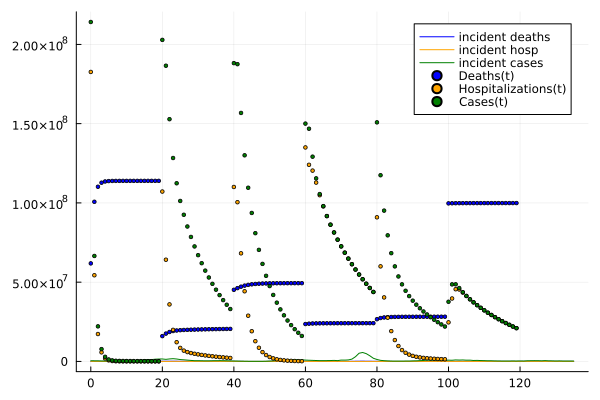

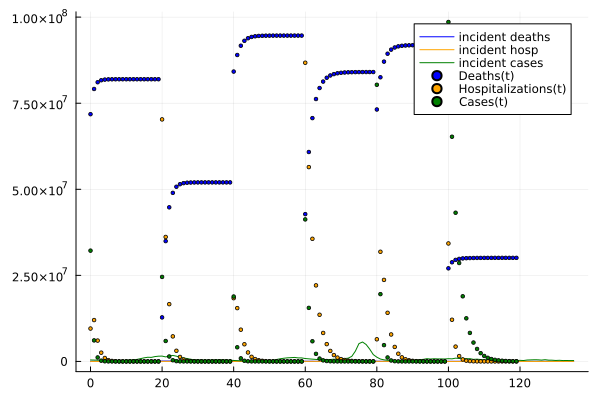

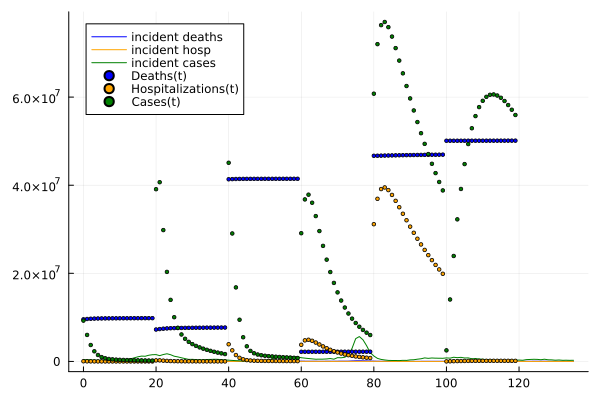

In [216]:
forecast_plts = [forecast_plot(df, ensemble_sol[1:2:end]) for ensemble_sol in ensemble_sols]
display.(forecast_plts);

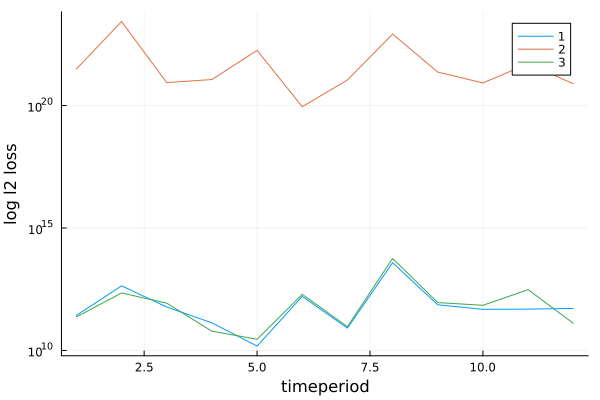

In [143]:
# this plot shows that the second model consistently underperforms for all timeperiods
ensemble_loss_plot(losses)

In [243]:
Matrix(dfi[:, 2:end])

20×3 Matrix{Int64}:
  426504   38039   7823
  396061   32638   7369
  372155   32164   7097
  299096   29605   6046
  292841   30061   6228
  281799   26604   5821
  256026   28030   5071
  291617   24191   5275
  286018   25358   5347
  300436   28491   4953
  348113   33744   5113
  394038   37562   5144
  493557   41729   5863
  589923   48331   6133
  818658   59224   7558
 1048060   73406   8317
 1212395   83419  11241
 1175780   88260  11034
 1406989   95431  16127
 1525551  102441  17509

In [144]:
dfi = dfs[1]
prbs = ensemble_remade_probs[:, 1]
# optimize linear conbination weights for the ensemble for first timeperiod
weights = optimize_ensemble_weights(prbs, dfi.t, Matrix(dfi[:, 2:end]); maxiters=1000)


u: 3-element Vector{Float64}:
 0.0017255699297669728
 0.0036421218440939322
 0.0014098391216699922

In [248]:
sum()

1.0

In [244]:
obs_sts

3-element Vector{Num}:
                   Deaths(t)
 Hospitalizations(t)
                 Cases(t)

In [179]:
# interface for solving collections of models at a time, used to do the second phase of optimization
eprob = EnsembleProblem(prbs; prob_func=(probs, i, reset) -> probs[i])
esol = solve(eprob; trajectories=length(prbs), saveat=dfi.t)
esol[obs_sts] # we can index into the ensemble

3-element Vector{Vector{Vector{Float64}}}:
 [[9.085121844854209e7, 1.1282358718232147e8, 1.4277440035822436e8], [1.0472264859305404e8, 5.409876297867355e7, 7.405937731783915e7], [1.1168273689926234e8, 2.486447085358743e7, 3.82432252739088e7], [1.1500827120140341e8, 1.123776209155629e7, 2.0265104025748566e7], [1.1655273905227587e8, 5.077644092335331e6, 1.121588065265333e7], [1.1726162582648183e8, 2.3252595929558845e6, 6.53500708536514e6], [1.1758736612839521e8, 1.0969784377439483e6, 4.011872940391536e6], [1.1773966528985785e8, 543241.140086521, 2.5826575924549634e6], [1.1781352791269842e8, 287742.5281070625, 1.7303661504202136e6], [1.1785140719026074e8, 165466.94538991986, 1.1977565083135036e6], [1.1787236982844421e8, 103592.16621793289, 850989.9133912385], [1.178850204448207e8, 69893.67231011037, 617370.9428134467], [1.1789330883604573e8, 49958.79377932563, 455578.93491216644], [1.1789912337154342e8, 37153.525656747544, 340846.17098173953], [1.1790339502621908e8, 28379.909890068666, 25

6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

In [223]:
# this recreates the covidhub df from the weighted ensemble for a single timeperiod
equal_ensemble_df = build_weighted_ensemble_df(fill(1/3, 3), esol)

20×4 DataFrame
 Row │ t        deaths     hosp            cases     
     │ Float64  Float64    Float64         Float64   
─────┼───────────────────────────────────────────────
   1 │     0.0  6.46478e7       6.68812e7  8.56776e7
   2 │     1.0  7.63944e7       2.76897e7  5.36487e7
   3 │     2.0  8.13613e7       1.16073e7  3.65919e7
   4 │     3.0  8.36256e7       4.9994e6   2.71136e7
   5 │     4.0  8.47768e7       2.2569e6   2.14077e7
   6 │     5.0  8.54493e7       1.09712e6  1.76386e7
   7 │     6.0  8.59016e7       5.92694e5  1.49323e7
   8 │     7.0  8.62425e7  363094.0        1.28612e7
  ⋮  │    ⋮         ⋮            ⋮             ⋮
  14 │    13.0  8.74435e7   99037.6        6.18643e6
  15 │    14.0  8.75726e7   87633.9        5.56517e6
  16 │    15.0  8.76889e7   78076.6        5.02347e6
  17 │    16.0  8.77943e7   69938.1        4.54883e6
  18 │    17.0  8.78898e7   62933.7        4.13132e6
  19 │    18.0  8.79768e7   56857.3        3.76263e6
  20 │    19.0  8.80562e7   51551.0        3.43569e6
                                       5 rows omitted

In [221]:
weighted_ensemble_df = build_weighted_ensemble_df(weights, esol)

20×4 DataFrame
 Row │ t        deaths          hosp           cases         
     │ Float64  Float64         Float64        Float64       
─────┼───────────────────────────────────────────────────────
   1 │     0.0       4.23469e5      5.11638e5      4.59395e5
   2 │     1.0       5.21039e5      1.96344e5      2.67571e5
   3 │     2.0       5.58321e5  76975.2            1.72578e5
   4 │     3.0       5.73504e5  31169.5            1.2298e5
   5 │     4.0       5.80339e5  13249.0        94717.4
   6 │     5.0       5.83889e5   6056.94       76875.5
   7 │     6.0       5.86062e5   3075.66       64492.7
   8 │     7.0       5.87603e5   1779.94       55235.0
  ⋮  │    ⋮           ⋮               ⋮              ⋮
  14 │    13.0       5.92758e5    430.703      26273.3
  15 │    14.0  593305.0          379.64       23619.5
  16 │    15.0       5.93798e5    337.193      21309.1
  17 │    16.0       5.94245e5    301.268      19287.4
  18 │    17.0       5.94649e5    270.495      17510.8
  19 │    18.0       5.95018e5    243.904      15943.2
  20 │    19.0       5.95354e5    220.764      14554.2
                                               5 rows omitted

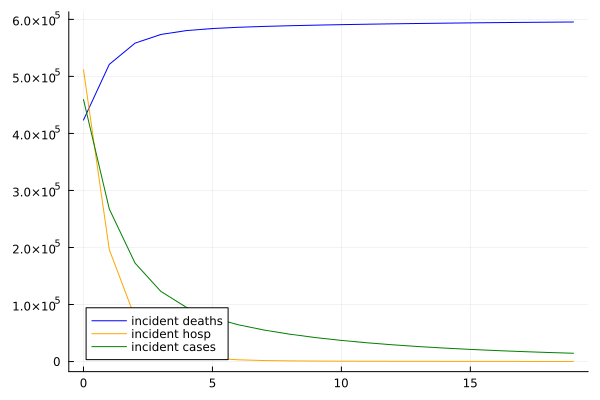

In [246]:
display(plot_covidhub(weighted_ensemble_df))

In [146]:
# this optimizes the weights for all timeperiods, returning a dataframe for the optimized weight for each model for each timeperiod
weights_df = build_all_weights_df(ensemble_remade_probs, dfs)

12×3 DataFrame
 Row │ x1           x2          x3          
     │ Float64      Float64     Float64     
─────┼──────────────────────────────────────
   1 │ 0.000512597  0.00507719  0.000147298
   2 │ 0.00110295   0.0135721   0.00319437
   3 │ 0.00023115   0.00552495  0.00152181
   4 │ 0.000233292  0.00317291  2.31565e-5
   5 │ 0.000959789  2.0357e-5   0.00933472
   6 │ 0.000750825  0.00748565  0.000713771
   7 │ 0.000631174  0.0049222   0.0196313
   8 │ 4.08624e-5   0.0150164   0.00205309
   9 │ 1.96381e-5   0.00843298  0.00428194
  10 │ 0.0014829    0.00343547  0.00231489
  11 │ 0.000759428  0.00365295  0.00675476
  12 │ 8.78728e-5   0.00414787  0.00051289

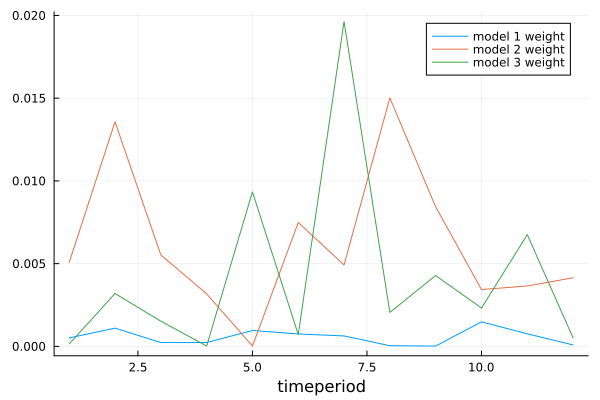

In [225]:
# see if the weights are consistent over time (which is consistent with ensemble_loss_plot(losses) above)
plt = plot(;xaxis="timeperiod")
plot!(plt, weights_df.x1; label="model 1 weight");
plot!(plt, weights_df.x2; label="model 2 weight");
plot!(plt, weights_df.x3; label="model 3 weight");
display(plt)

7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)


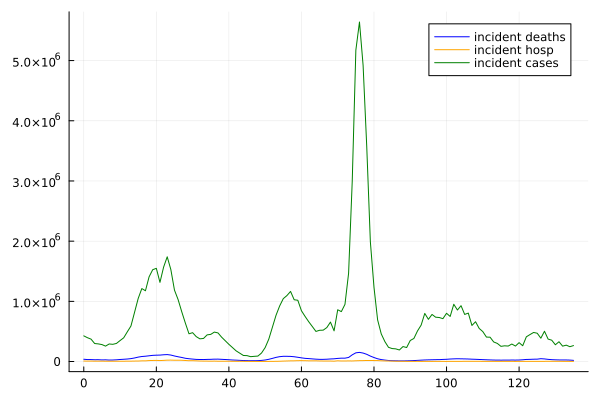

In [169]:
# to compare with below
plot_covidhub(df)

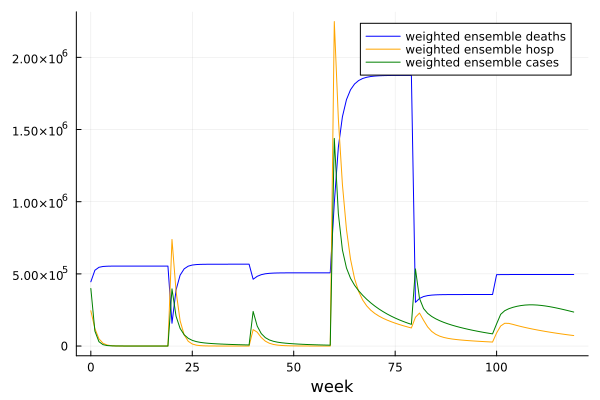

In [218]:
# plot the weighted ensemble stitched together into a covidhub df
xx = stitched_ensemble_df(ensemble_remade_probs, dfs);
full_weighted_ensemble = reduce(vcat, xx[1:2:end])
plt = plot_covidhub(full_weighted_ensemble; labs=["weighted ensemble deaths", "weighted ensemble hosp", "weighted ensemble cases"]);
xaxis!("week")

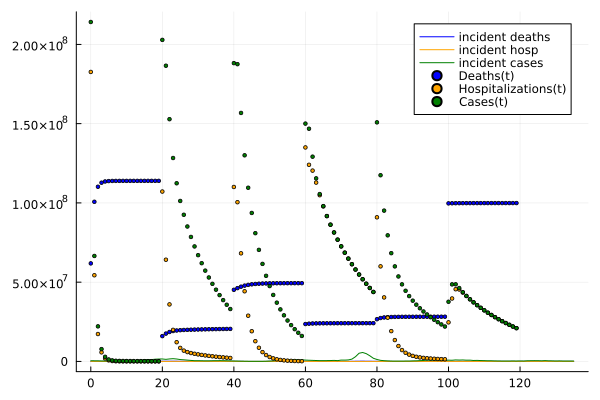

In [231]:
# single model plots again
forecast_plot(df, ensemble_sols[1][1:2:end])

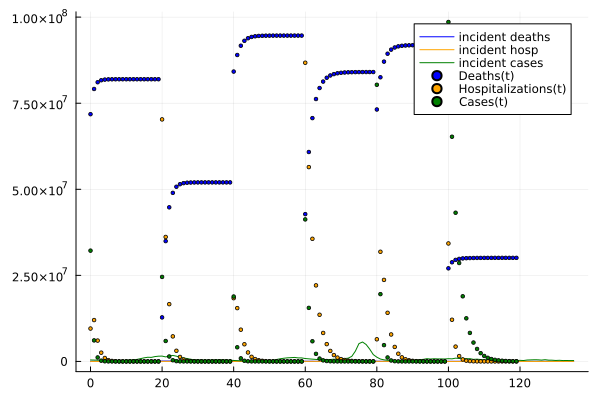

In [232]:
# single model plots again
forecast_plot(df, ensemble_sols[2][1:2:end])

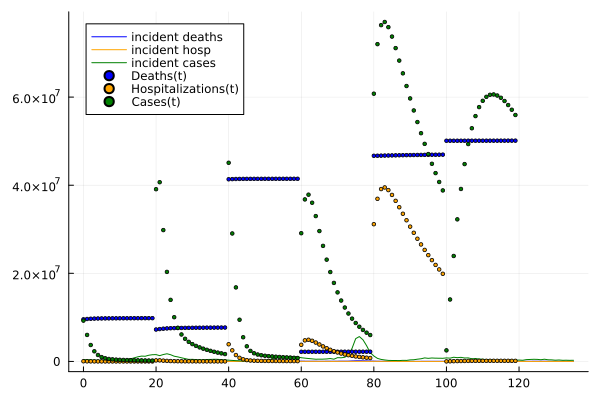

In [233]:
forecast_plot(df, ensemble_sols[3][1:2:end])